In [126]:
import numpy as np
import pandas as pd 
import plotly.graph_objects as go
import json
import os
import matplotlib.pyplot as plt

In [127]:

#Folder of the grid search you want to analyze, could be just one set of tested params in the 
#grid search 

gridsearch_folder = 'results/gridsearch_May6-05-40-10PM'

result_folders = [name for name in os.listdir(gridsearch_folder)]


## Warm Up Time Plots

In [128]:
def plot_warmup_graphs(gridsearch_folder, param_tokens = []):
    """
    For each set of parameters, plot the number of customers 
    already in each queue or being served (slow/fast) at each arrival time.
    Allows us to determine things go to steady state/when steady state happens.
    Plots are given by time and customer arrival index. 
    Do this for only one run, just to show that we are approx. evaluating the results at steady state. 
    Can use this plot to determine the number of warmup customers - how many initial records we discard
    (if any) because they are not the steadystate behavior. 
    
    gridsearch_folder - the folder of parameter sets to plot 
    param_tokens = list of params to label the runs by (parameter changes which defined the runs)
    """
    result_folders = [name for name in os.listdir(gridsearch_folder)]
    
    for param_results in result_folders:
     
        
        with open(f'{gridsearch_folder}/{param_results}/params.json') as file:
            param_dict = json.load(file)
            
            
        param_string = []
        for token in param_tokens:
            param_string.append(f'{token}: {param_dict[token]}')
        param_string = ', '.join(param_string)
        
        run_file = f'{gridsearch_folder}/{param_results}/customer_results_run_{0}.csv'
        run_df = pd.read_csv(run_file, index_col=0)
        
        for charge_type in ['Fast', 'Slow']:

            x_values = list(run_df['arrival_time'])
            y_values = list(run_df[f'L_{charge_type.lower()}'])

            # Create the plot
            fig = go.Figure()

            # Add a line trace
            fig.add_trace(go.Scatter(x=x_values, y=y_values, mode='lines', name='Line'))

            # Update layout
            fig.update_layout(title=f'Number of Customers in {charge_type} Queue Over Time ({param_string})',
                              xaxis_title='Time (Minutes)',
                              yaxis_title=f'Number of Customers in {charge_type} Queue')

            # Show the plot
            fig.show()

        for charge_type in ['Fast', 'Slow']:

            x_values = list(run_df.index)
            y_values = list(run_df[f'L_{charge_type.lower()}'])

            # Create the plot
            fig = go.Figure()

            # Add a line trace
            fig.add_trace(go.Scatter(x=x_values, y=y_values, mode='lines', name='Line'))

            # Update layout
            fig.update_layout(title=f'Number of Customers in {charge_type} Queue by Arrival ({param_string})',
                              xaxis_title='Customer Arrival Index',
                              yaxis_title=f'Number of Customers in {charge_type} Queue')

            # Show the plot
            fig.show()

In [129]:
plot_warmup_graphs(gridsearch_folder, ['p_fast'])

## Comparing the Impact of Price (on Consistent Non-Price Params)

We explore:

- How does cost change with p_fast? How much of this cost is from each group?
- How does average wait time (per customer) change with p_fast? Broken down by group?


Plots
   - Price vs. total cost 
   - Price vs. cost, per customer
   
   - Price vs. total cost for fast/slow/all customers 
   - Price vs. cost per fast/slow/all customers 
   
   - Price vs. total cost for ds/ps/all customers
   - Price vs. cost per ds/ps/all customers
   
   - Price vs. total wait
   - Price vs. wait, per customer
   
   - Price vs. total wait for fast/slow/all customers 
   - Price vs. wait per fast/slow/all customers 
   
   - Price vs. total wait for ds/ps/all customers
   - Price vs. wait per ds/ps/all customers

In [154]:

#Plotting p_fast price vs. total cost 
    
def plot_total_cost_vs_price_all(gridsearch_folder, n_warmup_cust = 0):
    
    
    result_folders = [name for name in os.listdir(gridsearch_folder)]
    
    
    #total costs, averaged over all runs for the corresponding price
    avg_total_costs = []
    avg_cost_per_cust = []
    
    #total cost for all fast customers, averaged over all runs for the corresponding price
    avg_total_fast_costs = []
    avg_cost_per_fast_cust = []
    
    #total cost for all slow customers, averaged over all runs for the corresponding price
    avg_total_slow_costs = []
    avg_cost_per_slow_cust = []

    #total cost for all ds customers, averaged over all runs for the corresponding price
    avg_total_ds_costs = []
    avg_cost_per_ds_cust = []
    
    #total cost for all ps customers, averaged over all runs for the corresponding price
    avg_total_ps_costs = []
    avg_cost_per_ps_cust = []
    
    #corresponding p_fast price
    p_fasts = []
    
    
    for param_results in result_folders:
        
        with open(f'{gridsearch_folder}/{param_results}/params.json') as file:
            param_dict = json.load(file)
            
        num_runs = param_dict['num_runs']
        
        #total cost, will be averaged over all runs after for loop
        runs_total_cost = 0
        
        runs_fast_cost = 0
        
        runs_slow_cost = 0
        
        runs_ds_cost = 0
        
        runs_ps_cost = 0
        
        n_customers = param_dict['num_customers'] - n_warmup_cust
        
        
        for run in range(num_runs):
            run_file = f'{gridsearch_folder}/{param_results}/customer_results_run_{run}.csv'
            
            run_df = pd.read_csv(run_file ,index_col = 0, skiprows=n_warmup_cust)
            
            runs_total_cost += run_df['true_cost'].sum()
            runs_fast_cost += run_df[run_df['charger_choice']=='fast']['true_cost'].sum()
            runs_slow_cost += run_df[run_df['charger_choice']=='slow']['true_cost'].sum()
            runs_ds_cost += run_df[run_df['sens_type']=='delay']['true_cost'].sum()
            runs_ps_cost += run_df[run_df['sens_type']=='price']['true_cost'].sum()
            
        

        avg_total_costs.append(runs_total_cost/num_runs)
        avg_cost_per_cust.append(avg_total_costs[-1]/n_customers)

        avg_total_fast_costs.append(runs_fast_cost/num_runs)
        avg_cost_per_fast_cust.append(avg_total_fast_costs[-1]/n_customers)

        avg_total_slow_costs.append(runs_slow_cost/num_runs)
        avg_cost_per_slow_cust.append(avg_total_slow_costs[-1]/n_customers)

        avg_total_ds_costs.append(runs_ds_cost/num_runs)
        avg_cost_per_ds_cust.append(avg_total_ds_costs[-1]/n_customers)

        avg_total_ps_costs.append(runs_ps_cost/num_runs)
        avg_cost_per_ps_cust.append(avg_total_ps_costs[-1]/n_customers)

        p_fasts.append(param_dict['p_fast'])
        
    p_fasts, avg_total_costs, avg_cost_per_cust,\
    avg_total_fast_costs, avg_cost_per_fast_cust,\
    avg_total_slow_costs, avg_cost_per_slow_cust,\
    avg_total_ds_costs, avg_cost_per_ds_cust,\
    avg_total_ps_costs, avg_cost_per_ps_cust= zip(*sorted(zip(p_fasts, avg_total_costs, avg_cost_per_cust,\
                                                  avg_total_fast_costs, avg_cost_per_fast_cust,\
                                                  avg_total_slow_costs, avg_cost_per_slow_cust,\
                                                  avg_total_ds_costs, avg_cost_per_ds_cust,\
                                                  avg_total_ps_costs, avg_cost_per_ps_cust)))
                                                      
                                                      
    #Plot total cost 
                                                      
    fig = go.Figure()
    fig.update_yaxes(rangemode="tozero")

    fig.add_trace(go.Scatter(x=p_fasts, y=avg_total_costs, mode='lines', name='Line'))

    fig.update_layout(title='Effect of Fast Charger Price on Total Cost',
                          xaxis_title='Fast Charger Price',
                          yaxis_title='Cost (Delay and Price)')

    fig.show()


    #Plot per capita
    fig = go.Figure()
    fig.update_yaxes(rangemode="tozero")
                                                      
    fig.add_trace(go.Scatter(x=p_fasts, y=avg_cost_per_cust, mode='lines', name='Line'))

    fig.update_layout(title='Effect of Fast Charger Price on Per Capita Cost',
                          xaxis_title='Fast Charger Price',
                          yaxis_title='Cost (Delay and Price)')

    fig.show()
                                                      
    #plot Total cost/total fast/total slow
                                                      
    fig = go.Figure()
    fig.update_yaxes(rangemode="tozero")
    fig.add_trace(go.Scatter(x=p_fasts, y=avg_total_costs, mode='lines', name='Total Cost', line=dict(color='blue')))

    fig.add_trace(go.Scatter(x=p_fasts, y=avg_total_fast_costs, mode='lines', name='Total Fast Charging Cost', line=dict(color='green')))

    fig.add_trace(go.Scatter(x=p_fasts, y=avg_total_slow_costs, mode='lines', name= 'Total Slow Charging Cost', line=dict(color='red')))

    fig.update_layout(title='Effect of Fast Charger Price on Total Cost',
                          xaxis_title='Fast Charger Price',
                          yaxis_title='Cost (Delay and Price)')

    fig.show()
                                                      
    #plot cost per capita from total/fast/slow 
                                                      
    fig = go.Figure()
    fig.update_yaxes(rangemode="tozero")

    fig.add_trace(go.Scatter(x=p_fasts, y=avg_cost_per_cust, mode='lines', name='Per Capita Cost', line=dict(color='blue')))

    fig.add_trace(go.Scatter(x=p_fasts, y=avg_cost_per_fast_cust, mode='lines', name='Per Capita Cost (Fast Charging)', line=dict(color='green')))

    fig.add_trace(go.Scatter(x=p_fasts, y=avg_cost_per_slow_cust, mode='lines', name= 'Per Capita Cost (Slow Charging)', line=dict(color='red')))

    fig.update_layout(title='Effect of Fast Charger Price on Per Capita Cost',
                          xaxis_title='Fast Charger Price',
                          yaxis_title='Cost (Delay and Price)')
                                                  
    fig.show()

                                                      
    #plot Total cost/total ds/total ps
                                              
                                                      
    fig = go.Figure()
    fig.update_yaxes(rangemode="tozero")

    fig.add_trace(go.Scatter(x=p_fasts, y=avg_total_costs, mode='lines', name='Total Cost', line=dict(color='blue')))

    fig.add_trace(go.Scatter(x=p_fasts, y=avg_total_ps_costs, mode='lines', name='Total Price-Sensitive Cost', line=dict(color='green')))

    fig.add_trace(go.Scatter(x=p_fasts, y=avg_total_ds_costs, mode='lines', name= 'Total Delay-Sensitive Cost', line=dict(color='red')))

    fig.update_layout(title='Effect of Fast Charger Price on Total Cost',
                          xaxis_title='Fast Charger Price',
                          yaxis_title='Cost (Delay and Price)')
        
    fig.show()
                                                      
                                                      
    #plot cost per customer from total/ds/ps
                                                      
                                                              
    fig = go.Figure()
    fig.update_yaxes(rangemode="tozero")
    fig.add_trace(go.Scatter(x=p_fasts, y=avg_cost_per_cust, mode='lines', name='Per Capita Cost', line=dict(color='blue')))

    fig.add_trace(go.Scatter(x=p_fasts, y=avg_cost_per_ps_cust, mode='lines', name='Per Capita Cost (Price-Sensitive)', line=dict(color='green')))

    fig.add_trace(go.Scatter(x=p_fasts, y=avg_cost_per_ds_cust, mode='lines', name= 'Per Capita Cost (Delay-Sensitive)', line=dict(color='red')))

    fig.update_layout(title='Effect of Fast Charger Price on Per Capita Cost',
                          xaxis_title='Fast Charger Price',
                          yaxis_title='Cost (Delay and Price)')
    
    fig.show()
                                                                        
        
    minimizing_idx = np.argmin(avg_total_costs)
        
    #minimizing p_fast cost and the total cost associated with it 
    min_cost = avg_total_costs[minimizing_idx]
    minimizing_price = p_fasts[minimizing_idx]
        
    return  min_cost, minimizing_price
    


In [155]:
plot_total_cost_vs_price_all(gridsearch_folder)

(3591264.016007693, 5)

In [163]:

#Plotting p_fast price vs. wait time in the queue
    
def plot_total_wait_vs_price_all(gridsearch_folder, n_warmup_cust = 0):
    
    """
    Plot how each group experiences wait time in the queue, ignoring time during service because obviously 
    the people who go through the slow vs. fast chargers have different service times
    
    In the variables below, "cost" is actually wait time (didn't want to rename all the variables from before)
    """
    
    
    result_folders = [name for name in os.listdir(gridsearch_folder)]
    
    
    #total costs, averaged over all runs for the corresponding price
    avg_total_costs = []
    avg_cost_per_cust = []
    
    #total cost for all fast customers, averaged over all runs for the corresponding price
    avg_total_fast_costs = []
    avg_cost_per_fast_cust = []
    
    #total cost for all slow customers, averaged over all runs for the corresponding price
    avg_total_slow_costs = []
    avg_cost_per_slow_cust = []

    #total cost for all ds customers, averaged over all runs for the corresponding price
    avg_total_ds_costs = []
    avg_cost_per_ds_cust = []
    
    #total cost for all ps customers, averaged over all runs for the corresponding price
    avg_total_ps_costs = []
    avg_cost_per_ps_cust = []
    
    #corresponding p_fast price
    p_fasts = []
    
    
    for param_results in result_folders:
        
        with open(f'{gridsearch_folder}/{param_results}/params.json') as file:
            param_dict = json.load(file)
            
        num_runs = param_dict['num_runs']
        
        #total cost, will be averaged over all runs after for loop
        runs_total_cost = 0
        
        runs_fast_cost = 0
        
        runs_slow_cost = 0
        
        runs_ds_cost = 0
        
        runs_ps_cost = 0
        
        n_customers = param_dict['num_customers'] - n_warmup_cust
        
        
        for run in range(num_runs):
            run_file = f'{gridsearch_folder}/{param_results}/customer_results_run_{run}.csv'
            
            run_df = pd.read_csv(run_file ,index_col = 0, skiprows=n_warmup_cust)
            
            runs_total_cost += run_df['true_queue_wait'].sum()
            runs_fast_cost += run_df[run_df['charger_choice']=='fast']['true_queue_wait'].sum()
            runs_slow_cost += run_df[run_df['charger_choice']=='slow']['true_queue_wait'].sum()
            runs_ds_cost += run_df[run_df['sens_type']=='delay']['true_queue_wait'].sum()
            runs_ps_cost += run_df[run_df['sens_type']=='price']['true_queue_wait'].sum()
            
        

        avg_total_costs.append(runs_total_cost/num_runs)
        avg_cost_per_cust.append(avg_total_costs[-1]/n_customers)

        avg_total_fast_costs.append(runs_fast_cost/num_runs)
        avg_cost_per_fast_cust.append(avg_total_fast_costs[-1]/n_customers)

        avg_total_slow_costs.append(runs_slow_cost/num_runs)
        avg_cost_per_slow_cust.append(avg_total_slow_costs[-1]/n_customers)

        avg_total_ds_costs.append(runs_ds_cost/num_runs)
        avg_cost_per_ds_cust.append(avg_total_ds_costs[-1]/n_customers)

        avg_total_ps_costs.append(runs_ps_cost/num_runs)
        avg_cost_per_ps_cust.append(avg_total_ps_costs[-1]/n_customers)

        p_fasts.append(param_dict['p_fast'])
        
    p_fasts, avg_total_costs, avg_cost_per_cust,\
    avg_total_fast_costs, avg_cost_per_fast_cust,\
    avg_total_slow_costs, avg_cost_per_slow_cust,\
    avg_total_ds_costs, avg_cost_per_ds_cust,\
    avg_total_ps_costs, avg_cost_per_ps_cust= zip(*sorted(zip(p_fasts, avg_total_costs, avg_cost_per_cust,\
                                                  avg_total_fast_costs, avg_cost_per_fast_cust,\
                                                  avg_total_slow_costs, avg_cost_per_slow_cust,\
                                                  avg_total_ds_costs, avg_cost_per_ds_cust,\
                                                  avg_total_ps_costs, avg_cost_per_ps_cust)))
                                                      
                                                      
    #Plot total cost 
    
    print(p_fasts)
                                                      
    fig = go.Figure()
    
    fig.update_yaxes(rangemode="tozero")

    fig.add_trace(go.Scatter(x=p_fasts, y=avg_total_costs, mode='lines', name='Line'))

    fig.update_layout(title='Effect of Fast Charger Price on Total Wait Time (Queue)',
                          xaxis_title='Fast Charger Price',
                          yaxis_title='Time in Queue (Minutes)')

    fig.show()


    #Plot per capita
    fig = go.Figure()
    
    fig.update_yaxes(rangemode="tozero")
                                                      
    fig.add_trace(go.Scatter(x=p_fasts, y=avg_cost_per_cust, mode='lines', name='Line'))

    fig.update_layout(title='Effect of Fast Charger Price on Wait Time Per Customer (Queue)',
                          xaxis_title='Fast Charger Price',
                          yaxis_title='Time in Queue (Minutes')

    fig.show()
                                                      
    #plot Total cost/total fast/total slow
                                                      
    fig = go.Figure()
    fig.update_yaxes(rangemode="tozero")

    fig.add_trace(go.Scatter(x=p_fasts, y=avg_total_costs, mode='lines', name='Total Wait Time', line=dict(color='blue')))

    fig.add_trace(go.Scatter(x=p_fasts, y=avg_total_fast_costs, mode='lines', name='Total Fast Charging Wait Time', line=dict(color='green')))

    fig.add_trace(go.Scatter(x=p_fasts, y=avg_total_slow_costs, mode='lines', name= 'Total Slow Charging Wait Time', line=dict(color='red')))

    fig.update_layout(title='Effect of Fast Charger Price on Total Wait Time (Queue)',
                          xaxis_title='Fast Charger Price',
                          yaxis_title='Time in Queue (Minutes')

    fig.show()
                                                      
    #plot cost per capita from total/fast/slow 
                                                      
    fig = go.Figure()
    fig.update_yaxes(rangemode="tozero")

    fig.add_trace(go.Scatter(x=p_fasts, y=avg_cost_per_cust, mode='lines', name='All', line=dict(color='blue')))

    fig.add_trace(go.Scatter(x=p_fasts, y=avg_cost_per_fast_cust, mode='lines', name='Fast Charging', line=dict(color='green')))

    fig.add_trace(go.Scatter(x=p_fasts, y=avg_cost_per_slow_cust, mode='lines', name= 'Slow Charging', line=dict(color='red')))

    fig.update_layout(title='Effect of Fast Charger Price on Wait Time Per Customer (Queue)',
                          xaxis_title='Fast Charger Price',
                          yaxis_title='Time in Queue (Minutes)')
                                                  
    fig.show()

                                                      
    #plot Total cost/total ds/total ps
                                              
                                                      
    fig = go.Figure()
    fig.update_yaxes(rangemode="tozero")

    fig.add_trace(go.Scatter(x=p_fasts, y=avg_total_costs, mode='lines', name='All', line=dict(color='blue')))

    fig.add_trace(go.Scatter(x=p_fasts, y=avg_total_ps_costs, mode='lines', name='Price-Sensitive', line=dict(color='green')))

    fig.add_trace(go.Scatter(x=p_fasts, y=avg_total_ds_costs, mode='lines', name= 'Delay-Sensitive', line=dict(color='red')))

    fig.update_layout(title='Effect of Fast Charger Price on Total Cost',
                          xaxis_title='Fast Charger Price',
                          yaxis_title='Time in Queue (Minutes)')
        
    fig.show()
                                                      
                                                      
    #plot cost per customer from total/ds/ps
                                                      
                                                              
    fig = go.Figure()
    fig.update_yaxes(rangemode="tozero")

    fig.add_trace(go.Scatter(x=p_fasts, y=avg_cost_per_cust, mode='lines', name='All', line=dict(color='blue')))

    fig.add_trace(go.Scatter(x=p_fasts, y=avg_cost_per_ps_cust, mode='lines', name='Price-Sensitive', line=dict(color='green')))

    fig.add_trace(go.Scatter(x=p_fasts, y=avg_cost_per_ds_cust, mode='lines', name= 'Delay-Sensitive', line=dict(color='red')))

    fig.update_layout(title='Effect of Fast Charger Price on Per Capita Cost',
                          xaxis_title='Fast Charger Price',
                          yaxis_title='Time in Queue (Minutes)')
    
    fig.show()
                                                                        
        
    minimizing_idx = np.argmin(avg_cost_per_cust)
        
    #wait-time minimizing p_fast cost and the per-customer wait associated with it
    min_cost = avg_cost_per_cust[minimizing_idx]
    minimizing_price = p_fasts[minimizing_idx]
        
    return  min_cost, minimizing_price
    


In [164]:
plot_total_wait_vs_price_all(gridsearch_folder)

(0, 1, 5)


(13.278441599277617, 5)

## Varying Model Parameters with Price

Under what settings is delay-differentiation useful?

Comparing optimal price for different parameter settings

Could use multi-line charts or contour plots (depending on the number of items in the grid search)

Contour plots are harder to read/interpret - basically shows how total cost changes as a param surface

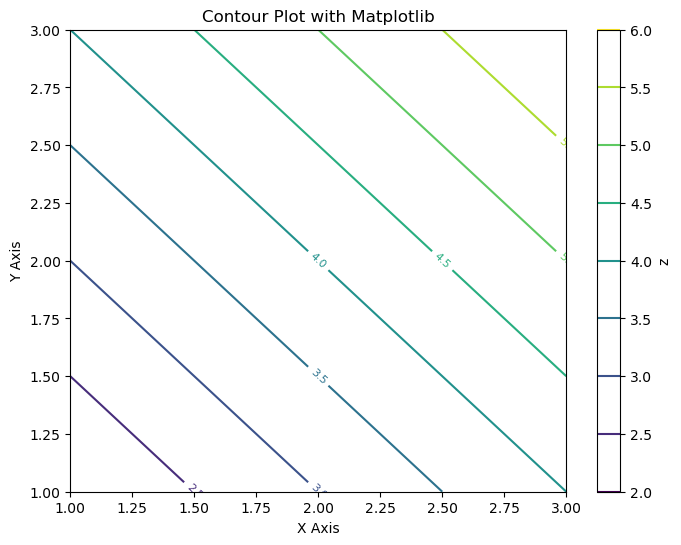

In [97]:

# Sample data
x = np.array([1, 2, 3])
y = np.array([1, 2, 3])
X, Y = np.meshgrid(x, y)
Z = X+Y

# Create the contour plot
plt.figure(figsize=(8, 6))
contour = plt.contour(X, Y, Z, cmap='viridis')
plt.colorbar(contour, label='z')

# Label the contour lines with their Z values
plt.clabel(contour, inline=True, fontsize=8)

# Add labels and title
plt.xlabel('X Axis')
plt.ylabel('Y Axis')
plt.title('Contour Plot with Matplotlib')

# Show the plot
plt.show()


In [88]:
x = np.linspace(-3, 3, 100)
y = np.linspace(-3, 3, 100)
X, Y = np.meshgrid(x, y)
Z = np.sin(np.sqrt(X**2 + Y**2))

In [94]:
Z

array([[-0.89168225, -0.87157792, -0.85012448, ..., -0.85012448,
        -0.87157792, -0.89168225],
       [-0.87157792, -0.8496589 , -0.8264126 , ..., -0.8264126 ,
        -0.8496589 , -0.87157792],
       [-0.85012448, -0.8264126 , -0.80139762, ..., -0.80139762,
        -0.8264126 , -0.85012448],
       ...,
       [-0.85012448, -0.8264126 , -0.80139762, ..., -0.80139762,
        -0.8264126 , -0.85012448],
       [-0.87157792, -0.8496589 , -0.8264126 , ..., -0.8264126 ,
        -0.8496589 , -0.87157792],
       [-0.89168225, -0.87157792, -0.85012448, ..., -0.85012448,
        -0.87157792, -0.89168225]])

In [96]:
x

array([-3.        , -2.93939394, -2.87878788, -2.81818182, -2.75757576,
       -2.6969697 , -2.63636364, -2.57575758, -2.51515152, -2.45454545,
       -2.39393939, -2.33333333, -2.27272727, -2.21212121, -2.15151515,
       -2.09090909, -2.03030303, -1.96969697, -1.90909091, -1.84848485,
       -1.78787879, -1.72727273, -1.66666667, -1.60606061, -1.54545455,
       -1.48484848, -1.42424242, -1.36363636, -1.3030303 , -1.24242424,
       -1.18181818, -1.12121212, -1.06060606, -1.        , -0.93939394,
       -0.87878788, -0.81818182, -0.75757576, -0.6969697 , -0.63636364,
       -0.57575758, -0.51515152, -0.45454545, -0.39393939, -0.33333333,
       -0.27272727, -0.21212121, -0.15151515, -0.09090909, -0.03030303,
        0.03030303,  0.09090909,  0.15151515,  0.21212121,  0.27272727,
        0.33333333,  0.39393939,  0.45454545,  0.51515152,  0.57575758,
        0.63636364,  0.6969697 ,  0.75757576,  0.81818182,  0.87878788,
        0.93939394,  1.        ,  1.06060606,  1.12121212,  1.18